In [1]:
import pandas as pd
df = pd.read_csv('un-general-debates-blueprint.csv')
df.head()

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."


In [3]:
import re
df['paragraphs'] = df["text"].map(lambda text: re.split(r'[.?!]\s*\n', text))
df['number_of_paragraphs'] = df['paragraphs'].map(len)

In [7]:
para_df = df.explode('paragraphs').reset_index()[['year', 'paragraphs']] # The 2020 mind cannot comprehend
para_df.head()

,year,paragraphs
0,1970,33: May I first convey to our President the co...
1,1970,34.\tIn taking up the work on the agenda of th...
2,1970,35.\tThe utilization of the United Nations to ...
3,1970,36.\tThe whole of progressive mankind recalls ...
4,1970,37.\tAll this has had well known consequences ...


<Axes: xlabel='year'>

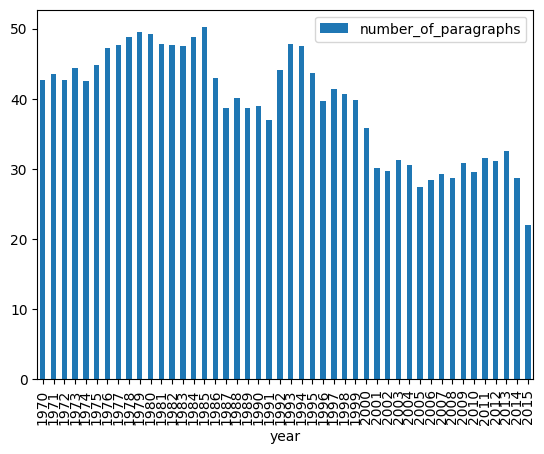

In [8]:
df.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar()

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
stopwords |= {"'ll", "'ve", "ll", "ve"}
tfidf_text = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7, ngram_range=(1, 3))
vectors_text = tfidf_text.fit_transform(df['text'])
vectors_text.shape

(7507, 426328)

In [41]:
tfidf_para = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7, ngram_range=(1, 3))
vectors_para = tfidf_para.fit_transform(para_df['paragraphs'])
vectors_para.shape

(287346, 421850)

In [42]:
from sklearn.decomposition import NMF
nmf_text = NMF(n_components=10, random_state=42)
W_text = nmf_text.fit_transform(vectors_text)
H_text = nmf_text.components_

In [50]:
def display_topics(model, feature_names, no_top_words):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        print("Topic %02d" % topic)
        for i in range(no_top_words):
            print(" %s: %.2f" % (feature_names[largest[i]], word_vector[largest[i]]/total*100.0))
            
        

In [44]:
display_topics(nmf_text, tfidf_text.get_feature_names_out(), 10)

Topic 00
 co: 0.28
 co operation: 0.26
 operation: 0.23
 disarmament: 0.10
 relations: 0.09
 europe: 0.08
 nuclear: 0.08
 detente: 0.08
 developing countries: 0.07
 negotiations: 0.06
Topic 01
 african: 0.22
 africa: 0.16
 republic: 0.12
 congo: 0.11
 central african: 0.10
 burundi: 0.10
 guinea: 0.09
 republic congo: 0.09
 central african republic: 0.08
 african republic: 0.08
Topic 02
 africa: 0.26
 south: 0.22
 south africa: 0.19
 namibia: 0.13
 african: 0.12
 independence: 0.10
 apartheid: 0.10
 regime: 0.09
 delegation: 0.08
 developing countries: 0.08
Topic 03
 arab: 0.28
 israel: 0.25
 lebanon: 0.17
 palestinian: 0.17
 israeli: 0.16
 iraq: 0.14
 resolutions: 0.11
 lebanese: 0.09
 kuwait: 0.09
 occupation: 0.09
Topic 04
 climate change: 0.26
 climate: 0.22
 change: 0.19
 2015: 0.17
 sustainable: 0.16
 development goals: 0.12
 sustainable development: 0.12
 goals: 0.12
 mdgs: 0.11
 post 2015: 0.11
Topic 05
 american: 0.14
 america: 0.13
 latin: 0.13
 panama: 0.10
 bolivia: 0.10
 d

In [45]:
W_text.sum(axis=0)/W_text.sum()*100.0

array([ 9.57678958, 11.62732278, 11.45181005,  9.31810399,  8.70932634,
       13.21064324,  7.3001485 ,  4.35816519, 17.49412328,  6.95356705])

In [46]:
nmf_para = NMF(n_components=10, random_state=42)
W_para = nmf_para.fit_transform(vectors_para)
H_para = nmf_para.components_
display_topics(nmf_para, tfidf_para.get_feature_names_out(), 10)

Topic 00
 international: 0.53
 world: 0.39
 peace: 0.29
 community: 0.28
 international community: 0.24
 new: 0.21
 states: 0.18
 political: 0.18
 war: 0.17
 country: 0.16
Topic 01
 nations: 1.84
 united: 1.80
 united nations: 1.80
 organization: 0.37
 charter: 0.29
 states: 0.25
 member: 0.25
 role: 0.24
 member states: 0.17
 secretary: 0.17
Topic 02
 general: 1.02
 assembly: 0.99
 session: 0.95
 general assembly: 0.87
 mr: 0.62
 president: 0.56
 session general: 0.50
 session general assembly: 0.50
 election: 0.47
 secretary: 0.32
Topic 03
 east: 0.72
 middle: 0.68
 middle east: 0.68
 palestinian: 0.62
 israel: 0.56
 people: 0.50
 peace: 0.46
 arab: 0.44
 palestinian people: 0.37
 palestine: 0.32
Topic 04
 rights: 2.28
 human: 2.19
 human rights: 2.06
 respect: 0.36
 respect human: 0.30
 respect human rights: 0.29
 universal: 0.29
 fundamental: 0.27
 protection: 0.26
 violations: 0.24
Topic 05
 nuclear: 1.90
 weapons: 1.26
 nuclear weapons: 0.77
 disarmament: 0.67
 treaty: 0.66
 prol

In [47]:
W_para.sum(axis=0)/W_para.sum()*100.0

array([14.97753552, 14.14488482,  9.98099942,  8.32899179,  6.56196774,
        5.85947961,  8.83279683,  8.34537967, 10.5458025 , 12.42216209])

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7, ngram_range=(1, 3))
count_para_vectors = count_para_vectorizer.fit_transform(para_df['paragraphs'])
from sklearn.decomposition import LatentDirichletAllocation
lda_para = LatentDirichletAllocation(n_components=10, random_state=42)
W_lda_para = lda_para.fit_transform(count_para_vectors)
H_lda_para = lda_para.components_

In [49]:
display_topics(lda_para, count_para_vectorizer.get_feature_names_out(), 10)

Topic 00
 nations: 3.73
 united nations: 3.41
 united: 3.40
 international: 1.08
 organization: 0.87
 peace: 0.78
 security: 0.63
 world: 0.56
 charter: 0.54
 states: 0.53
Topic 01
 united: 0.81
 countries: 0.75
 nations: 0.69
 states: 0.67
 conference: 0.66
 development: 0.63
 united nations: 0.55
 international: 0.47
 cooperation: 0.43
 support: 0.40
Topic 02
 africa: 1.17
 south: 0.96
 people: 0.75
 south africa: 0.66
 independence: 0.60
 peoples: 0.55
 right: 0.45
 united: 0.45
 namibia: 0.45
 states: 0.43
Topic 03
 countries: 2.13
 economic: 1.56
 world: 1.29
 international: 1.23
 developing: 0.85
 development: 0.75
 developing countries: 0.69
 problems: 0.51
 co: 0.49
 new: 0.46
Topic 04
 people: 0.86
 world: 0.79
 country: 0.50
 change: 0.43
 climate: 0.37
 resources: 0.36
 climate change: 0.28
 human: 0.28
 cent: 0.27
 years: 0.27
Topic 05
 human: 1.79
 rights: 1.59
 development: 1.53
 human rights: 1.18
 world: 0.58
 international: 0.51
 global: 0.48
 social: 0.43
 sustainable